# Permutation Feature Importance
https://scikit-learn.org/stable/modules/permutation_importance.html  

This is a good way to score feature importance in the context of a specific classifier/model.  
The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.  
The idea comes from the original work on Random Forests by Leo Breiman:  
L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

#### Image Segmentation Data

In [54]:
seg_data = pd.read_csv('segmentation-all.csv')
print(seg_data.shape)
seg_data.head()

(2310, 20)


,Class,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,BRICKFACE,140.0,125.0,9,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333334,7.666666,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
1,BRICKFACE,188.0,133.0,9,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666666,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
2,BRICKFACE,105.0,139.0,9,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333334,3.333333,-7.666666,7.555555,0.532628,-0.965946
3,BRICKFACE,34.0,137.0,9,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
4,BRICKFACE,39.0,111.0,9,0.0,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


In [55]:
seg_data['Class'].describe()

count       2310
unique         7
top       CEMENT
freq         330
Name: Class, dtype: object

In [56]:
y = seg_data.pop('Class').values
X = seg_data.values

In [57]:
seg_scaler = preprocessing.MinMaxScaler().fit(X)
X_scaled = seg_scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=2, test_size=1/2)

In [58]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_perm = permutation_importance(knn, X_train, y_train, 
                                n_repeats=10, random_state=0)

In [59]:
knn_perm.importances_mean

array([ 7.34199134e-02,  1.81125541e-01,  0.00000000e+00,  8.48484848e-03,
        5.97402597e-03,  1.02164502e-02, -1.73160173e-04,  5.19480519e-03,
       -7.79220779e-04,  1.29004329e-02,  1.18614719e-02,  1.98268398e-02,
        1.06493506e-02,  6.45887446e-02,  1.52380952e-02,  2.17316017e-02,
        2.00000000e-02,  1.34372294e-01,  1.64415584e-01])

In [60]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_perm = permutation_importance(gnb, X_train, y_train, 
                                n_repeats=10, random_state=0)

In [61]:
pfi = dict()
for i,j in zip(seg_data.columns,knn_perm.importances_mean):
    pfi[i]=j

In [78]:
df = pd.DataFrame.from_dict(pfi,orient='index',columns=['kNN-FI'])
df['GNB-FI'] = gnb_perm.importances_mean
df.sort_values(by=['kNN-FI'],ascending=False,inplace=True)
df.head(-5)

,kNN-FI,GNB-FI
REGION-CENTROID-ROW,0.181126,0.107100
HUE-MEAN,0.164416,0.205801
SATURATION-MEAN,0.134372,0.103983
REGION-CENTROID-COL,0.073420,0.008485
EXRED-MEAN,0.064589,0.051515
EXGREEN-MEAN,0.021732,0.038268
VALUE-MEAN,0.020000,0.110476
RAWBLUE-MEAN,0.019827,0.125628
EXBLUE-MEAN,0.015238,0.054632
INTENSITY-MEAN,0.012900,0.061126


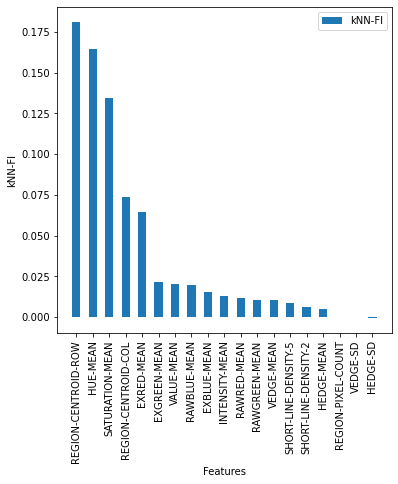

In [79]:
n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(df.index, df["kNN-FI"], label='kNN-FI',width=.5)
ax.set_xticks(list(df.index))
ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('kNN-FI')
ax.legend()
ax.figure.savefig("kNN-FI.png", bbox_inches='tight', dpi=150)
plt.show()

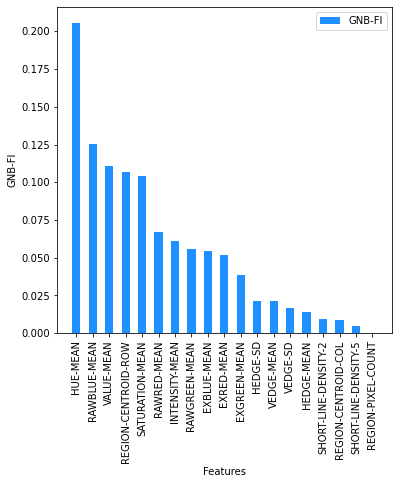

In [80]:
df.sort_values(by=['GNB-FI'],ascending=False,inplace=True)
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(df.index, df["GNB-FI"], label='GNB-FI',width=.5, color="dodgerblue")
ax.set_xticks(list(df.index))
ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('GNB-FI')
ax.legend()
ax.figure.savefig("GNB-FI.png", bbox_inches='tight', dpi=150)
plt.show()

In [82]:
from scipy import stats
stats.spearmanr(df['kNN-FI'], df['GNB-FI'])

SpearmanrResult(correlation=0.6298245614035087, pvalue=0.0038527412830699653)